In [1]:
import sys
import os

# This adds the parent directory (root) to the python path
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
	sys.path.append(module_path)

In [2]:
# load data
import pandas as pd

df = pd.read_csv("../data/data.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share,first_word,last_word,len_diff,freq_sum,freq_diff,sim_score
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,91.67,1,0,2,1.386294,0.000000,0.891514
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,41.18,1,0,5,2.708050,0.510826,0.667445
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,20.00,1,0,4,1.386294,0.000000,0.499448
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by,0,0.00,0,0,2,1.386294,0.000000,0.135825
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,25.00,1,0,6,2.079442,0.693147,0.212026


In [3]:
from sklearn.model_selection import train_test_split

# define features
features = df.drop(columns=["id", "qid1", "qid2", "question1", "question2", "is_duplicate"]).columns
X = df[features]
y = df["is_duplicate"]

# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import torch
import xgboost as xgb

# define random search space
random_grid = {
	"n_estimators": [500, 1000, 1500, 2000, 2500, 3000],
	"max_depth": [2, 3, 4, 5, 6, 7, 8],
	"learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05],
	"subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
	"colsample_bytree": [0.7, 0.8, 0.9, 1],
	"gamma": [0, 0.1, 0.2, 0.3, 0.4], # min_split_loss
	"reg_alpha": [0, 0.1, 0.15, 0.2, 0.25], # l1_regularization
	"reg_lambda": [1.5, 1.75, 2, 2.25], # l2_regularization
}

# initialize the base model
device = "cuda" if torch.cuda.is_available() else "cpu"
xgb_model = xgb.XGBClassifier(tree_method="hist", device=device, random_state=42)

# setup random search
random_search = RandomizedSearchCV(
	estimator = xgb_model,
	param_distributions = random_grid,
	n_iter = 33, # number of iterations
	scoring = "neg_log_loss", # used instead of accuracy since classification problem
	cv = StratifiedKFold(n_splits=3), # imbalanced dataset
	random_state = 42,
	n_jobs = 1, # use all cores
)

# run random search
random_search.fit(X_train, y_train)

c:\Users\Rahul\Documents\Personal Projects\.py\question-similarity\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:19:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.75, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.02, ...], 'max_depth': [2, 3, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",33
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_log_loss'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used h

In [ ]:
# define grid search space
best = random_search.best_params_
grid_param = {
	"n_estimators": [best["n_estimators"]-100, best["n_estimators"], best["n_estimators"]+100],
	"max_depth": [best["max_depth"]-1, best["max_depth"], best["max_depth"]+1],
	"learning_rate": [best["learning_rate"]],
	"subsample": [best["subsample"]],
	"colsample_bytree": [best["colsample_bytree"]],
	"gamma": [best["gamma"]],
	"reg_alpha": [best["reg_alpha"]],
	"reg_lambda": [best["reg_lambda"]]
}

# setup grid search
grid_search = GridSearchCV(
	estimator = xgb_model,
	param_grid = grid_param,
	scoring = "neg_log_loss", # used instead of accuracy since classification problem
	cv = StratifiedKFold(n_splits=3), # imbalanced dataset
	n_jobs = 1, # use all cores
	error_score = "raise"
)

# run grid search
grid_search.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.9], 'gamma': [0], 'learning_rate': [0.03, 0.04, ...], 'max_depth': [4, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_log_loss'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo...shuffle=False)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time fo

In [6]:
from sklearn.metrics import log_loss, f1_score, roc_auc_score, precision_score, recall_score

best_model = grid_search.best_estimator_

# predict
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

metrics = {
	"log_loss": log_loss(y_test, y_proba),
	"f1_score": f1_score(y_test, y_pred),
	"roc_auc": roc_auc_score(y_test, y_proba),
	"precision": precision_score(y_test, y_pred),
	"recall": recall_score(y_test, y_pred)
}

for k,v in metrics.items():
	print(f"{k}: {v:.4f}")

log_loss: 0.2763
f1_score: 0.8310
roc_auc: 0.9490
precision: 0.8322
recall: 0.8299


In [7]:
# create comparision dataframe for the test set
comparison_df = pd.DataFrame()

# add the target and predictions
comparison_df["actual_is_duplicate"] = y_test.values
comparison_df["predicted_is_duplicate"] = y_pred
comparison_df["predicted_proba_is_duplicate"] = y_proba
comparison_df["sim_score"] = df["sim_score"]

comparison_df.head()

,actual_is_duplicate,predicted_is_duplicate,predicted_proba_is_duplicate,sim_score
0,0,0,0.012849,0.891514
1,0,0,0.111077,0.667445
2,0,0,0.456972,0.499448
3,1,0,0.484548,0.135825
4,0,0,0.000378,0.212026


In [8]:
# looking at cases where sbert was high but it wasnt a duplicate
hard_cases = comparison_df[(comparison_df["sim_score"] > 0.7) & (comparison_df["actual_is_duplicate"] == 0)]
soft_cases = comparison_df[(comparison_df["sim_score"] < 0.3) & (comparison_df["actual_is_duplicate"] == 1)]
tricky_cases = len(hard_cases[hard_cases["predicted_is_duplicate"] == 0]) + len(soft_cases[soft_cases["predicted_is_duplicate"] == 1])
print(f"number of tricky cases: {tricky_cases}")
print(f"percent of unreliable data: {((tricky_cases / comparison_df.shape[0]) * 100):.2f}%")

number of tricky cases: 28519
percent of unreliable data: 35.27%


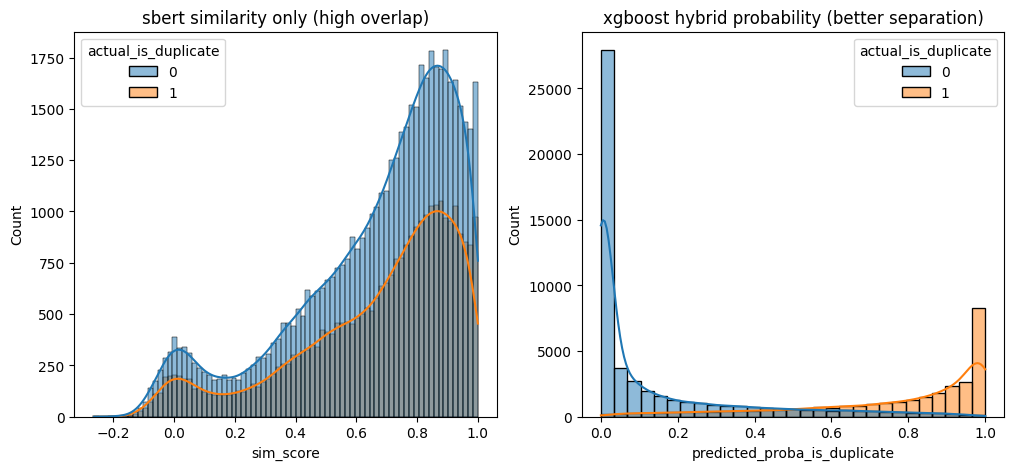

In [9]:
# visual comparison to show why dual stage model is better than a single transformer approach
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# sbert similarity score (raw transformer output)
plt.subplot(1,2,1)
sns.histplot(data=comparison_df, x="sim_score", hue="actual_is_duplicate", kde=True)
plt.title("sbert similarity only (high overlap)")

# xgboost predicted probability (hybrid output)
plt.subplot(1,2,2)
sns.histplot(data=comparison_df, x="predicted_proba_is_duplicate", hue="actual_is_duplicate", kde=True)
plt.title("xgboost hybrid probability (better separation)")

plt.show()

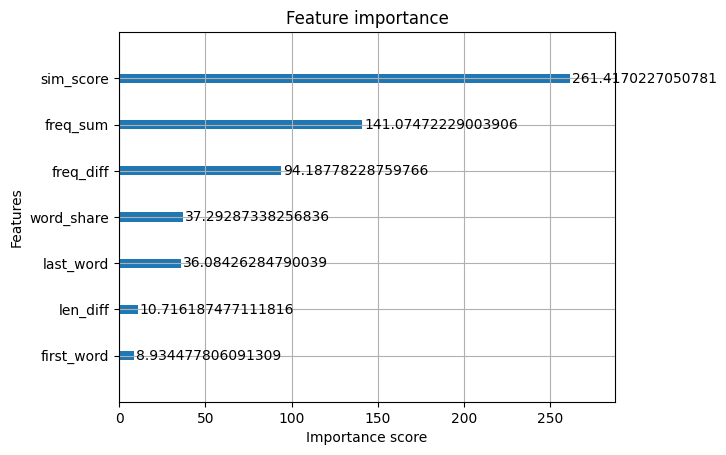

In [10]:
xgb.plot_importance(best_model, importance_type="gain")
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# Initialize a standard RF
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

# Train and Predict
rf_model.fit(X_train, y_train)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Random Forest Log Loss: {log_loss(y_test, rf_proba):.4f}")
print(f"XGBoost Log Loss (Baseline): 0.2764")

Random Forest Log Loss: 0.2807
XGBoost Log Loss (Baseline): 0.2764
